<a href="https://colab.research.google.com/github/tololojo/AML_FinalProject/blob/master/train_hyperUNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load libraries

In [1]:
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5]
from glob import glob
import os
from copy import deepcopy
from tqdm import tqdm

import numpy as np
import cv2
from PIL import Image

import torch
from torch.utils.data import Dataset
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from torchvision.transforms import v2, functional
from torchvision import transforms
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras

# Lorenz's libs
# import math
import pandas as pd
import requests
from io import BytesIO
# from pyproj import Proj, Transformer
import random
# from tqdm import tqdm
# import folium
# from folium.plugins import MarkerCluster

# Define helper functions/classes

In [2]:
## convert RGB to the personal LAB (LAB2)
# the input R,G,B,  must be 1D from 0 to 255
# the outputs are 1D  L [0 1], a [-1 1] b [-1 1]
def RGB2LAB2(R0, G0, B0):

    R=R0/255
    G=G0/255
    B=B0/255

    # Y=0.3*R + 0.59*G + 0.11*B
    # X=0.45*R + 0.35*G + 0.2*B
    # Z=0.01*R + 0.09*G + 0.9*B

    Y=0.299*R + 0.587*G + 0.114*B
    X=0.449*R + 0.353*G + 0.198*B
    Z=0.012*R + 0.089*G + 0.899*B

    # X - Y = 0.150*R - 0.234*G + 0.084*B  = a0
    # Y - Z = 0.287*R + 0.498*G - 0.785*B  = b0

    L = Y
    a = (X - Y)/0.234
    b = (Y - Z)/0.785

    return L, a, b

## convert the personal LAB (LAB2)to the RGB
# the input L,a,b,  must be 1D L [0 1], a [-1 1] b [-1 1]
# the outputs are 1D  R g B [0 255]
def LAB22RGB(L, a, b):

    a11 = 0.299
    a12 = 0.587
    a13 = 0.114
    a21 = (0.15/0.234)
    a22 = (-0.234/0.234)
    a23 = (0.084/0.234)
    a31 = (0.287/0.785)
    a32 = (0.498/0.785)
    a33 = (-0.785/0.785)

    aa=np.array([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])
    C0=np.zeros((L.shape[0],3))
    C0[:,0]=L[:,0]
    C0[:,1]=a[:,0]
    C0[:,2]=b[:,0]
    C = np.transpose(C0)
    # C = np.array([L, a, b])
    # print(C.shape)
    # print(L.shape)
    # print(a.shape)
    # print(b.shape)
    # print(aa.shape)

    X = np.linalg.inv(aa).dot(C)
    X1D=np.reshape(X,(X.shape[0]*X.shape[1],1))
    p0=np.where(X1D<0)
    X1D[p0[0]]=0
    p1=np.where(X1D>1)
    X1D[p1[0]]=1
    Xr=np.reshape(X1D,(X.shape[0],X.shape[1]))

    Rr = Xr[0][:]
    Gr = Xr[1][:]
    Br = Xr[2][:]

    R = np.uint(np.round(Rr*255))
    G = np.uint(np.round(Gr*255))
    B = np.uint(np.round(Br*255))
    # p0=np.where(L<0.02)
    # R[p0[0]]=0
    # G[p0[0]]=0
    # B[p0[0]]=0
    # p1=np.where(L>0.98)
    # R[p1[0]]=255
    # G[p1[0]]=255
    # B[p1[0]]=255
    return R, G, B

# def convert_to_feed_model_func(RGB_image):

#     sz0=RGB_image.shape[0]
#     sz1=RGB_image.shape[1]

#     train_imgs=np.zeros((sz0,sz1,2))
#     train_input=np.zeros((sz0,sz1,1))

#     ab=np.zeros((sz0,sz1,2))
#     R1 = np.reshape(RGB_image[:,:,0],(sz0*sz1,1))
#     G1 = np.reshape(RGB_image[:,:,1],(sz0*sz1,1))
#     B1 = np.reshape(RGB_image[:,:,2],(sz0*sz1,1))
#     L, A, B = RGB2LAB2(R1,G1,B1)
#     A = np.reshape(A,(sz0,sz1))
#     B = np.reshape(B,(sz0,sz1))
#     ab[:,:,0] = A
#     ab[:,:,1] = B
#     train_input[:,:,:] =  np.reshape(L,(1,sz0,sz1,1))
#     train_imgs[:,:,:] = np.reshape(ab,(1,sz0,sz1,2))

#     return (train_input, train_imgs)


In [3]:
def plot_transform(orig_img, imgs, with_orig=True, row_title=None, img_size = 10, **imshow_kwargs):

    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False, figsize = (img_size, img_size))
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

# Define custom Dataset class


In [4]:
# the idea was borrowed from here: https://towardsdatascience.com/custom-dataset-in-pytorch-part-1-images-2df3152895

class Swisstopodataset(Dataset):
    def __init__(self, img_indx, transform = None, large_dataset=False, return_label = True):
        self.img_indx = img_indx
        self.transform = transform
        self.large_dataset = large_dataset
        self.return_label = return_label
        # self.augment = augment

    def __len__(self):
        return len(self.img_indx)

    def __getitem__(self, idx):
        # img_filepath  = self.img_indx[idx]
        if self.large_dataset:
            port = 1986
        else:
            port = 1985
        raw_data_csv_file_link = f"https://perritos.myasustor.com:{port}/metadata.csv"
        metadata_file = pd.read_csv(raw_data_csv_file_link, index_col=0)
        img_in_server_link = f"https://perritos.myasustor.com:{port}/data/img_id_{self.img_indx[idx]}.jpg"
        response = requests.get(img_in_server_link)
        image = Image.open(BytesIO(response.content))
        # image = cv2.imread(img_filepath)
        # image = Image.fromarray(image)

        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # define here a label if existing
        label = metadata_file["class"].iloc[idx]

        if self.transform is not None:
            # print ("*** Transforming RGB img to LAB ***")
            image = self.transform(image)

        # if self.augment is not None:
        #     # print ("*** Applying augmentation on L channel ***")
        #     image_L, imageAB = image
        #     image_L = self.augment(image_L)
        #     image = (image_L, imageAB)


        if self.return_label:
            return image, label
        else:
            return image


# Define transforms


In [5]:
# class convert_RGB_to_feed_model(torch.nn.Module):
#     def forward(self, img):
#         img = np.asanyarray(img)
#         sz0=img.shape[0]
#         sz1=img.shape[1]

#         train_imgs=np.zeros((sz0,sz1,2))
#         train_input=np.zeros((sz0,sz1,1))

#         ab=np.zeros((sz0,sz1,2))
#         R1 = np.reshape(img[:,:,0],(sz0*sz1,1))
#         G1 = np.reshape(img[:,:,1],(sz0*sz1,1))
#         B1 = np.reshape(img[:,:,2],(sz0*sz1,1))
#         L, A, B = RGB2LAB2(R1,G1,B1)
#         A = np.reshape(A,(sz0,sz1))
#         B = np.reshape(B,(sz0,sz1))
#         ab[:,:,0] = A
#         ab[:,:,1] = B
#         train_input[:,:,:] =  np.reshape(L,(1,sz0,sz1,1))
#         train_imgs[:,:,:] = np.reshape(ab,(1,sz0,sz1,2))
#         return (train_input, train_imgs)

class convert_RGB_to_feed_model(torch.nn.Module):
    def forward(self, img):
        img = np.asanyarray(img)
        sz_x=img.shape[0]
        sz_y=img.shape[1]

        train_imgs=np.zeros((sz_x,sz_y,2))
        train_input=np.zeros((sz_x,sz_y,1))

        ab=np.zeros((sz_x,sz_y,2))
        R1 = np.reshape(img[:,:,0],(sz_x*sz_y,1))
        G1 = np.reshape(img[:,:,1],(sz_x*sz_y,1))
        B1 = np.reshape(img[:,:,2],(sz_x*sz_y,1))
        L, A, B = RGB2LAB2(R1,G1,B1)
        # A = np.reshape(A,(sz_x,sz_y))
        # B = np.reshape(B,(sz_x,sz_y))
        # ab[:,:,0] = A
        # ab[:,:,1] = B
        # print(f"shape of ab is: {ab.shape}")
        # print(f"shape of L is: {L.shape}")
        # train_input[:,:,:] =  np.reshape(L,(1,sz_x,sz_y,1))
        # train_imgs[:,:,:] = np.reshape(ab,(1,sz_x,sz_y,2))

        train_input[:,:,0] = L.reshape((sz_x,sz_y))
        train_imgs[:,:,0] = np.reshape(A,(sz_x,sz_y))
        train_imgs[:,:,1] = np.reshape(B,(sz_x,sz_y))

        # print(f"shape of train_input is: {train_input.shape}")
        # print(f"shape of train_imgs is: {train_imgs.shape}")

        return (train_input, train_imgs)

In [6]:
# NOTE: need to crate a transform class to revert from model to RGB, so the oposite from the class convert_RGB_to_feed_model
class convert_from_LAB_to_RGB(torch.nn.Module):
    def forward(self, img_raw):
        image, _ = img_raw
        print(image.shape)
        # sz0 = image.shape[0]
        # sz1 = image.shape[1]
        # sz2 = image.shape[2]
        # LAB_img = np.reshape(LAB_img,(sz0*sz1,bands))
        # Ar = LAB_img[:,0:1]
        # Br = LAB_img[:,1:2]

        # Rr, Gr, Br = LAB22RGB(L,Ar,Br)
        # Rr = np.reshape(Rr,(sz0,sz1))
        # Gr = np.reshape(Gr,(sz0,sz1))
        # Br = np.reshape(Br,(sz0,sz1))
        # predicted255=np.uint8(np.zeros((sz0,sz1,3)))
        # predicted255[:,:,0] = Rr
        # predicted255[:,:,1] = Gr
        # predicted255[:,:,2] = Br
        # return (predicted255)

# NOTE: for Lorenz

here bellow you can try to apply the transformations as we checked in chatgpt.

Transformation missing are:
- flipping (vertical / horizontal)
- add noise
- change brightness
- change contras
- adjust gamma? may be not...
- others?


In [7]:
# class AddGaussianNoise(object):
#     def __init__(self, mean=0., std=1., probability= 0.5):
#         self.std = std
#         self.mean = mean
#         assert 0 <= probability <= 1, "Probability must be between 0 and 1"
#         self.probability = probability

#     def __call__(self, img):
#         if random.random() < self.probability:
#           return img + torch.randn(img.size()) * self.std + self.mean
#         return img

#     def __repr__(self):
#         return self.__class__.__name__ + '(mean={0}, std={1}, probability={2})'.format(self.mean, self.std, self.probability)


# # def addnoise(input_image, noise_factor = 0.3):
# #     inputs = transforms.ToTensor(input_image)
# #     noise = inputs + torch.rand_like(inputs) * noise_factor
# #     noise = torch.clip (noise,0,1.)
# #     output_image = T.ToPILImage()
# #     image = output_image(noise)
# #     return image

# # gausian_image_3 = addnoise(orig_img)
# # gausian_image_6 = addnoise(orig_img,0.6)
# # gausian_image_9 = addnoise(orig_img,0.9)

# class AddGaussianNoise(object):
#     def __ini__(self, noise_factor = 0.3, probability= 0.5):
#       assert 0 <= noise_factor <= 1, "noise_factor must be between 0 and 1"
#       self.noise_factor = noise_factor
#       assert 0 <= probability <= 1, "Probability must be between 0 and 1"
#       self.probability = probability

#     def __call__(self, img):
#       print(self.noise_factor)
#       print(self.probability)
#       if random.random() < self.probability:
#         inputs = transforms.ToTensor()(img)
#         noise = inputs + torch.rand_like(inputs) * self.noise_factor
#         noise = torch.clip (noise,0,1.)
#         return transforms.ToPILImage()(noise)

#       return img





# class AddGaussianNoise(object):
#     def __init__(self, mean=0., std=1.):
#         self.std = std
#         self.mean = mean

#     def __call__(self, tensor):
#         print(self.std)
#         return tensor + torch.randn(tensor.size()) * self.std + self.mean

#     def __repr__(self):
#         return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)



And then here bellow, you can chained them inside the `augment_transform` construct.

**NOTE**: as an alternative approach we can always try to apply the transformation on the RGB image and at the really end change it to LAB (as it is in the code bellow). I guess this will also work?

In [8]:
# We set to 20% of images will be subject to transformation
perc_apply_trasnform = 0.2


# This transformation will only change the image colorspace from RGB->LAB
RGBtoLAB_transforms = transforms.Compose(
    [
        # v2.ToImage(), # convert to tensor if you have a PIL image. NOTE: when you do this it convert the image automatically to RGB!!! Be carefull!
        convert_RGB_to_feed_model(),
    ]
)

augment_transform = transforms.Compose(
    [
        # v2.ToImage(), # convert to tensor if you have a PIL image. NOTE: when you do this it convert the image automatically to RGB!!! Be carefull!
        v2.RandomHorizontalFlip(p=perc_apply_trasnform),
        v2.RandomHorizontalFlip(p=perc_apply_trasnform),
        v2.ColorJitter(brightness = 0.5),
        v2.ColorJitter(contrast = 0.5),
        convert_RGB_to_feed_model(),

    ]
)


## Check transformations

In [9]:
# retrieve a sample image
test_index_img = 1550
url = f"https://perritos.myasustor.com:1985/data/img_id_{test_index_img}.jpg"
# url = "https://192.168.1.144:1985/data/img_id_0.jpg"
response = requests.get(url)
img_test = Image.open(BytesIO(response.content))
# plt.imshow(img_test)

A acouple of examples on how to visualize the transformations that you apply (on colorized images)

In [10]:
perc_apply_transform = 1
n = 8


Flipping Horizontal

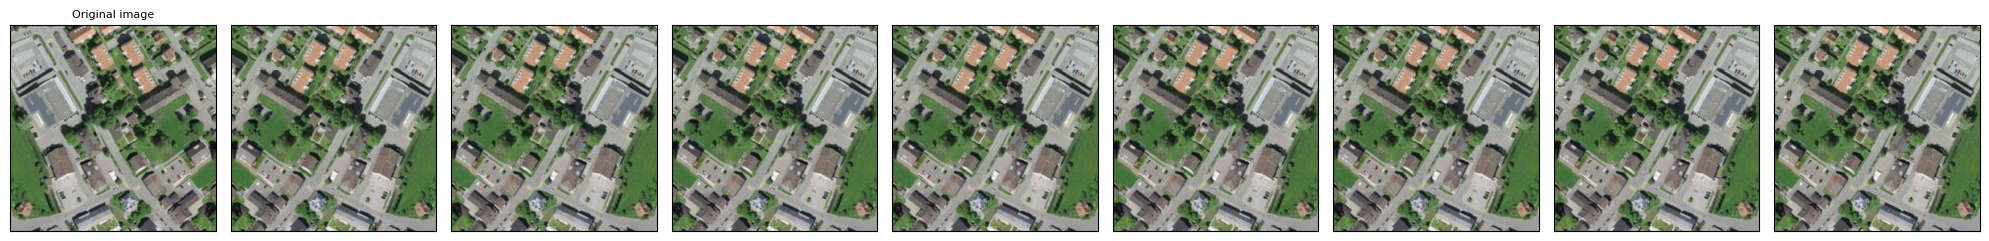

In [11]:
plot_transform(img_test, [v2.RandomHorizontalFlip(p=perc_apply_transform)(img_test) for _ in range(n)], img_size=20) # this works as expected

changing brightness

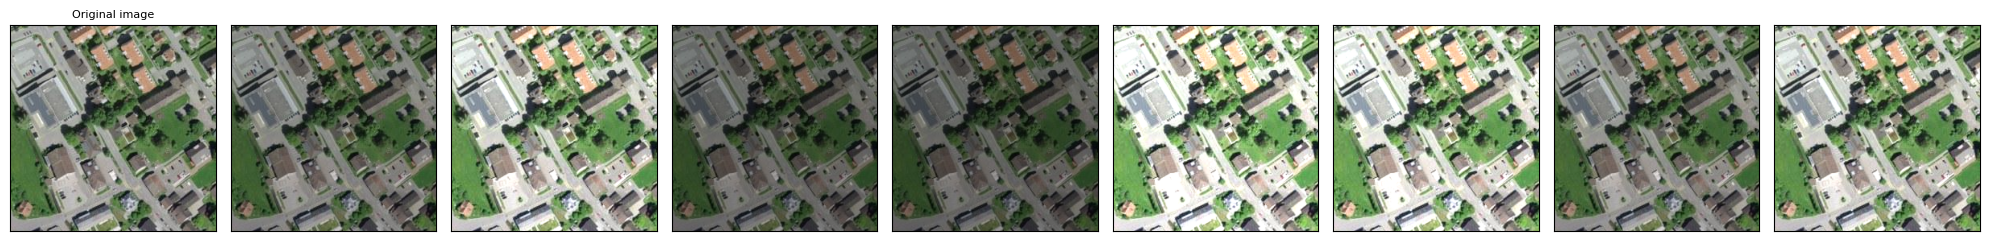

In [12]:
plot_transform(img_test, [v2.ColorJitter(brightness = (0.5, 1.5))(img_test) for _ in range(n)], img_size = 20) # this works as expected

changing contrast

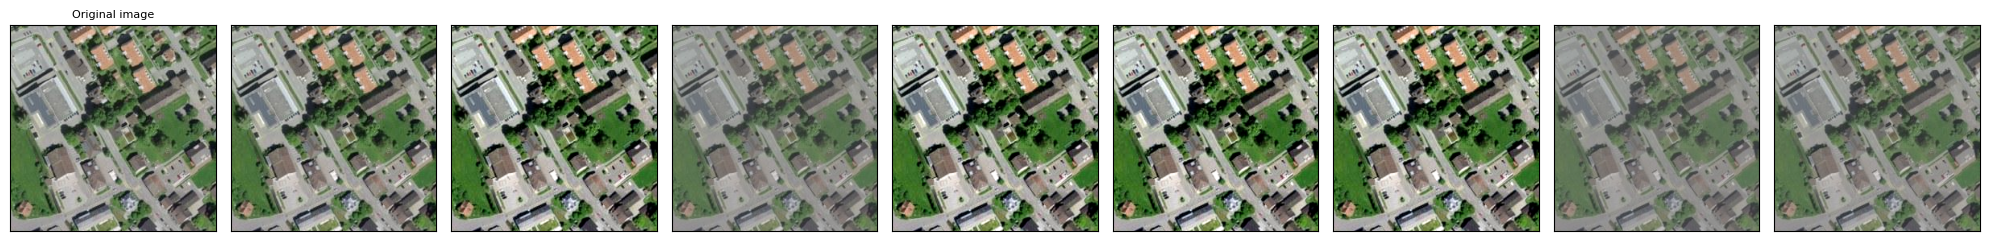

In [13]:
plot_transform(img_test, [v2.ColorJitter(contrast = (0.5, 1.5))(img_test) for _ in range(n)], img_size = 20) # this works as expected

changing to LAB

NOTE: take the first index (L channel) after applying transformation

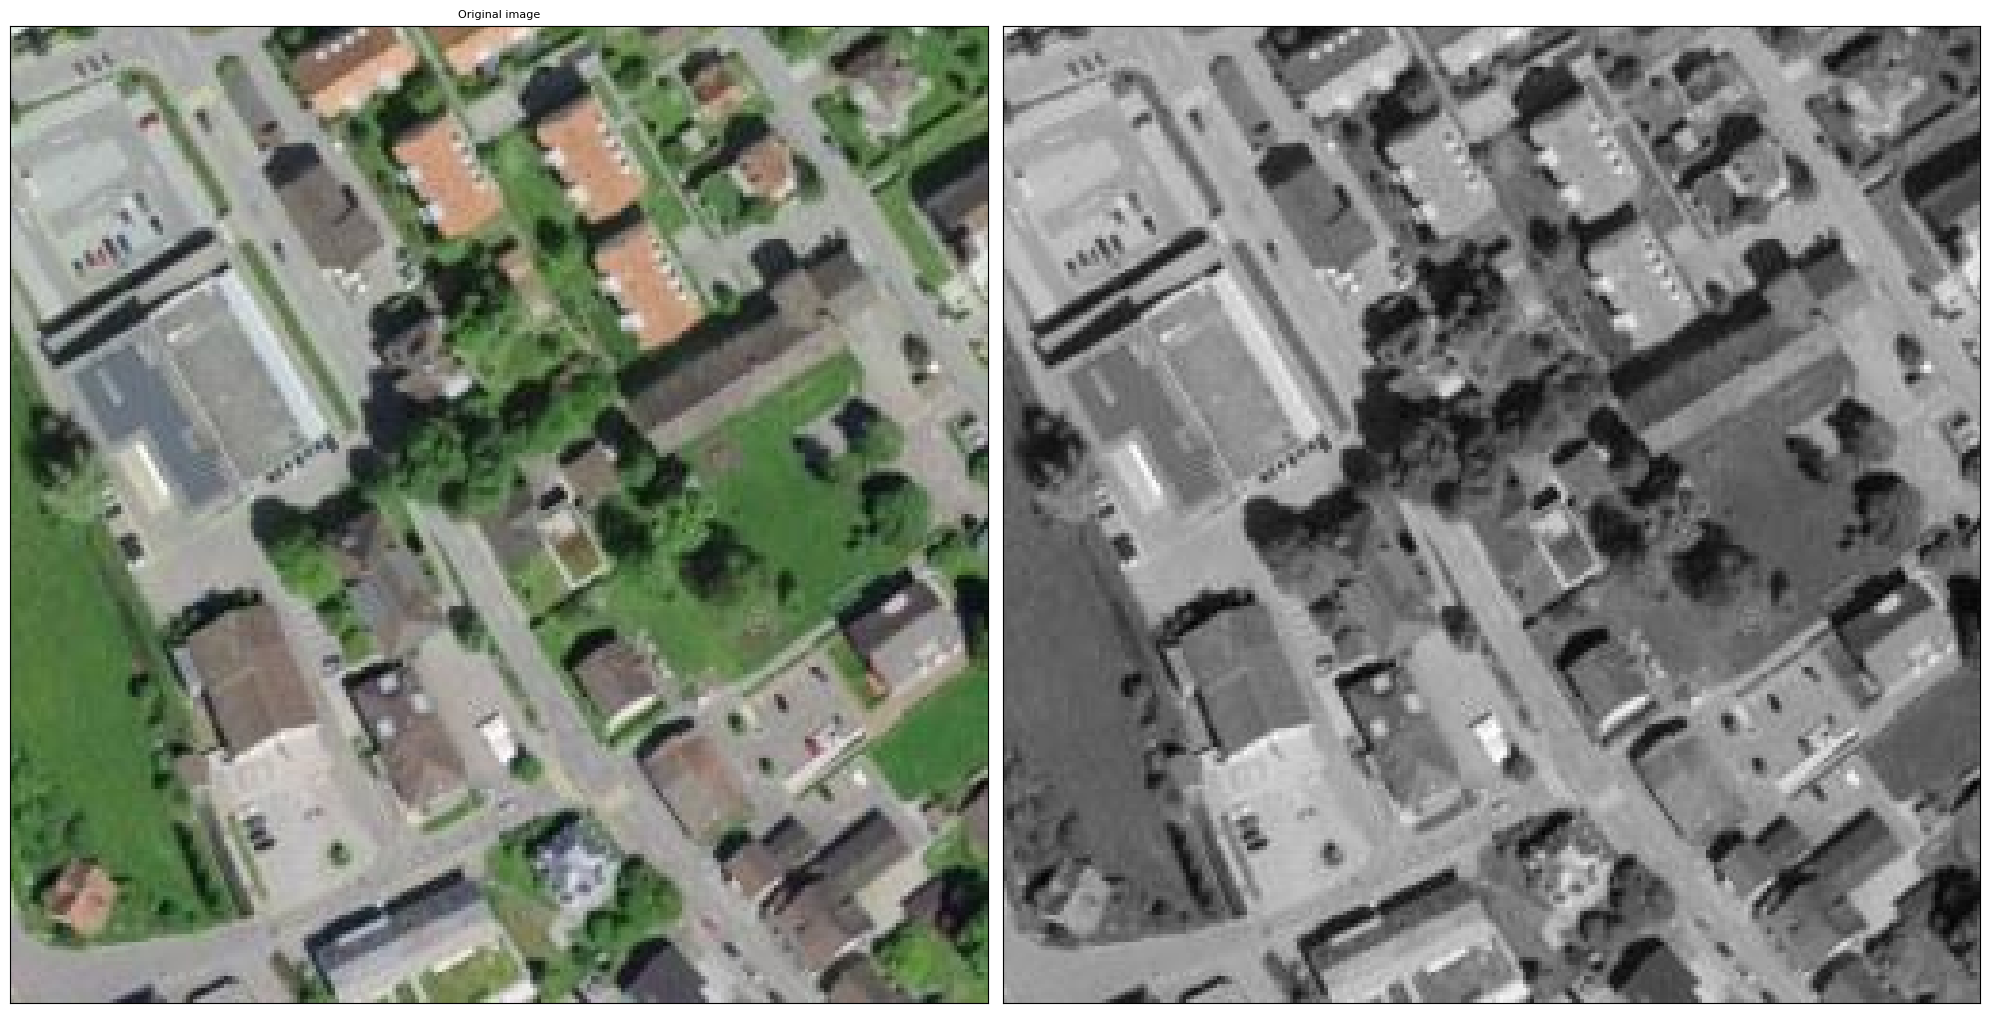

In [14]:
plot_transform(img_test, [convert_RGB_to_feed_model()(img_test)[0] for _ in range(1)], img_size = 20, cmap = "gray")


# Check info from the images

The data was initially created using the scripts `retrieve_data.ipynb` and stored in a private server for later (re)use.
In the metadata.csv file we get the information on original link, class and coordinates of each image.

NOTE: the following are links stored in a private server, jet they are still publically available.

In [15]:
is_large_dataset = True

if is_large_dataset:
    server_port = 1986 # Large dataset of ~10K images
else:
    server_port = 1985 # Large dataset of ~10K images
# server_port = 1985 # initial dataset of 3.6K images

raw_data_csv_file_link = f"https://perritos.myasustor.com:{server_port}/metadata.csv"


metadata_raw_df = pd.read_csv(raw_data_csv_file_link, index_col=0)
metadata_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10008 entries, 0 to 10007
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   img_id      10008 non-null  int64  
 1   img_name    10008 non-null  object 
 2   latitude    10008 non-null  float64
 3   longitude   10008 non-null  float64
 4   zoom_level  10008 non-null  int64  
 5   class       10008 non-null  int64  
 6   link        10008 non-null  object 
dtypes: float64(2), int64(3), object(2)
memory usage: 625.5+ KB


# Split the Train, Valid and Test subsets.

We use the column `image_id` from the metadata as index of the images and then we perform standard shufling and splitting.

The final ratio for the train, validation and test dastasets are: 70, 29 and 1 % respectively

In [16]:
dataX, dataY = metadata_raw_df["img_id"].to_list(), metadata_raw_df["class"] .to_list()

rand_state = 9898
train_ratio = 0.70
validation_ratio = 0.29
test_ratio = 0.01



# train is now 75% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, test_size=1 - train_ratio, stratify = dataY, random_state=rand_state)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), stratify=y_test, random_state=rand_state)

print(f"the size fo the train dataset is: {len(x_train)}.\nthe size fo the validation dataset is: {len(x_val)}.\nthe size fo the test dataset is: {len(x_test)}.")

the size fo the train dataset is: 7005.
the size fo the validation dataset is: 2902.
the size fo the test dataset is: 101.


In [17]:
# Create train_dataset, valid_dataset, and test_dataset
train_dataset = Swisstopodataset(x_train,
                                 large_dataset=is_large_dataset,
                                 return_label=False,
                                 transform=augment_transform)

valid_dataset = Swisstopodataset(x_val,
                                 large_dataset=is_large_dataset,
                                 return_label=False,
                                 transform=augment_transform)

test_dataset = Swisstopodataset(x_test,
                                large_dataset=is_large_dataset,
                                return_label=False,
                                transform=RGBtoLAB_transforms)

# Get the sizes of the datasets
train_size = len(train_dataset)
valid_size = len(valid_dataset)
test_size = len(test_dataset)

# Print the sizes of the datasets
print(f"Size of train_dataset: {train_size}")
print(f"Size of valid_dataset: {valid_size}")
print(f"Size of test_dataset: {test_size}")


Size of train_dataset: 7005
Size of valid_dataset: 2902
Size of test_dataset: 101


Dig in an example to check the shape of the content

In [18]:
for img in test_dataset:
    print(f"object of type: {type(img)}. len of object: {len(img)}")
    print(f"the first element of the object is of type: {type(img[0])} of shape: {img[0].shape}")
    print(f"the second element of the object is of type: {type(img[1])} of shape: {img[1].shape}")
    break

object of type: <class 'tuple'>. len of object: 2
the first element of the object is of type: <class 'numpy.ndarray'> of shape: (256, 256, 1)
the second element of the object is of type: <class 'numpy.ndarray'> of shape: (256, 256, 2)


In [19]:
def convert_to_tensor(L_channel, AB_channel):
    # Convert to TensorFlow tensors and cast to float32
    L_tensor = tf.cast(tf.convert_to_tensor(L_channel), dtype=tf.float32)
    AB_tensor = tf.cast(tf.convert_to_tensor(AB_channel), dtype=tf.float32)

    return L_tensor, AB_tensor

def create_tf_dataset(dataset, desc):
    # Create a TensorFlow dataset from the input dataset
    tf_dataset = tf.data.Dataset.from_generator(lambda: dataset, output_types=(tf.uint8, tf.uint8))

    # Apply the conversion function to each element of the dataset in parallel
    tf_dataset = tf_dataset.map(convert_to_tensor, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    return tf_dataset

In [20]:
# Create TensorFlow datasets for train, validation, and test sets
tf_train_dataset = create_tf_dataset(train_dataset, 'Creating Train Dataset')
tf_valid_dataset = create_tf_dataset(valid_dataset, 'Creating Validation Dataset')
tf_test_dataset = create_tf_dataset(test_dataset, 'Creating Test Dataset')

Instructions for updating:
Use output_signature instead


In [21]:
# Take a sample from the TensorFlow dataset
sample = next(iter(tf_train_dataset))

# Print the shape of the sample
L_shape = sample[0].shape
AB_shape = sample[1].shape
print("Shape of L channel:", L_shape)
print("Shape of AB channel:", AB_shape)


Shape of L channel: (256, 256, 1)
Shape of AB channel: (256, 256, 2)


# Retrain Hpyer UNet

In [22]:
!gdown --id 19DaA9f1HIOW9PmUz11xKw65fCo3X7-Fw --output Hyper_U_Net.h5

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=19DaA9f1HIOW9PmUz11xKw65fCo3X7-Fw
From (redirected): https://drive.google.com/uc?id=19DaA9f1HIOW9PmUz11xKw65fCo3X7-Fw&confirm=t&uuid=8b3cfcba-0db9-48ea-835b-8d1c2c1c0b57
To: /content/Hyper_U_Net.h5
100% 500M/500M [00:05<00:00, 96.3MB/s]


Load the pretrained model and freeze the encoder

In [23]:
# Define the file path of the downloaded model
model_file_path = '/content/Hyper_U_Net.h5'

# Load the saved model
loaded_model = tf.keras.models.load_model(model_file_path)

# Find the index of the last encoder layer
last_encoder_layer_index = loaded_model.layers.index(loaded_model.get_layer('max_pooling2d_4'))

# Freeze all layers up to the last encoder layer
for layer in loaded_model.layers[:last_encoder_layer_index + 1]:
    layer.trainable = False

# Function to count the number of parameters
def count_params(model, only_trainable=False):
    if only_trainable:
        return np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    else:
        return np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights + model.non_trainable_weights])

# Get the number of trainable and non-trainable parameters
trainable_params = count_params(loaded_model, only_trainable=True)
total_params = count_params(loaded_model)

print(f"Trainable parameters: {trainable_params}")
print(f"Total parameters: {total_params}")

# Display model summary
loaded_model.summary()

Trainable parameters: 26901698
Total parameters: 41615234
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 1)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 64)       640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, None, None, 64)       36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, None, None, 64)       0         ['conv2d_1[0][0]']            
 D)                                 

In [24]:
# Compile the model after freezing the encoder layers
loaded_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [25]:
# Calculate steps per epoch
batch_size = 16
train_steps_per_epoch = train_size // batch_size
valid_steps_per_epoch = valid_size // batch_size

# Shuffle, repeat, and batch the datasets
train_data = tf_train_dataset.shuffle(buffer_size=train_size).repeat().batch(batch_size)
valid_data = tf_valid_dataset.shuffle(buffer_size=valid_size).repeat().batch(batch_size)
test_data = tf_test_dataset.batch(batch_size)


In [26]:
# Check shapes of a few individual samples directly from the dataset
L_sample, AB_sample = next(iter(tf_train_dataset))
print(f"L_sample shape: {L_sample.shape}")
print(f"AB_sample shape: {AB_sample.shape}")

L_sample, AB_sample = next(iter(tf_valid_dataset))
print(f"L_sample shape: {L_sample.shape}")
print(f"AB_sample shape: {AB_sample.shape}")

L_sample, AB_sample = next(iter(tf_test_dataset))
print(f"L_sample shape: {L_sample.shape}")
print(f"AB_sample shape: {AB_sample.shape}")


L_sample shape: (256, 256, 1)
AB_sample shape: (256, 256, 2)
L_sample shape: (256, 256, 1)
AB_sample shape: (256, 256, 2)
L_sample shape: (256, 256, 1)
AB_sample shape: (256, 256, 2)


for ruben:

here I tried to get the shape of the batches because of the error "    ValueError: as_list() is not defined on an unknown TensorShape.
" when trying to train it

In [30]:
import time

def print_batch_shapes(dataset, description):
    start_time = time.time()
    for L_batch, AB_batch in dataset.take(1):
        print(f"{description} - L_batch shape: {L_batch.shape}, AB_batch shape: {AB_batch.shape}")
    end_time = time.time()
    print(f"Time taken to check {description}: {end_time - start_time} seconds")


In [29]:
# Function to prepare the dataset for training with caching and prefetching
def prepare_dataset(dataset, buffer_size, batch_size, is_training=True):
    if is_training:
        dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Temporary smaller dataset for debugging
small_train_data = tf_train_dataset.take(10)  # Take only 10 samples for quick testing
small_valid_data = tf_valid_dataset.take(10)
small_test_data = tf_test_dataset.take(10)

# Prepare the smaller datasets
train_data_small = prepare_dataset(small_train_data, buffer_size=10, batch_size=batch_size, is_training=True)
valid_data_small = prepare_dataset(small_valid_data, buffer_size=10, batch_size=batch_size, is_training=False)
test_data_small = prepare_dataset(small_test_data, buffer_size=10, batch_size=batch_size, is_training=False)

# Check shapes of batches with transformations applied on smaller dataset
print_batch_shapes(train_data_small, "Small Train data")
print_batch_shapes(valid_data_small, "Small Validation data")
print_batch_shapes(test_data_small, "Small Test data")


Small Train data - L_batch shape: (10, 256, 256, 1), AB_batch shape: (10, 256, 256, 2)
Time taken to check Small Train data: 18.36886692047119 seconds
Small Validation data - L_batch shape: (10, 256, 256, 1), AB_batch shape: (10, 256, 256, 2)
Time taken to check Small Validation data: 18.31676197052002 seconds
Small Test data - L_batch shape: (10, 256, 256, 1), AB_batch shape: (10, 256, 256, 2)
Time taken to check Small Test data: 18.40753674507141 seconds


In [27]:
# Training the model
epochs = 1
history = loaded_model.fit(train_data,
                           validation_data=valid_data,
                           epochs=epochs,
                           steps_per_epoch=train_steps_per_epoch,
                           validation_steps=valid_steps_per_epoch)


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1155, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1249, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 592, in update_state
        self.build(y_pred, y_true)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 498, in build
        self._metrics = tf.__internal__.nest.map_structure_up_to(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 646, in _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 646, in <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 667, in _get_metric_object
        y_t_rank = len(y_t.shape.as_list())

    ValueError: as_list() is not defined on an unknown TensorShape.
